In [2]:
import json
import gzip
import datetime
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
from collections import Counter

# Video Metadata

In this part, we focus on processing the video metadata file. Two goals are to be achieved: 

1) **Filter relevent videos**: This is the core step in our data processing pipeline which target videos regarding `Mental Health` are retrieved for further processing and visualization. At the same time, we plan to retrieve videoes of other topics so that comparison can be made between different trends to further validate our hypothesis.

2) **Visualize inner trend within target videos**: This is to explore how societies focus within mental health has transformed from 2015 to 2019, if we could acquire any deeper insights into the specific topic. Plots are expected to drawn in a meaningful way to support our ideas.

## Filter relevent videos

**Method (snowball keywords matching)**

The method we use to retrieve relevent videos is based on the string matching of keywords. The idea is that:

1) We design a list of keywords ourselves that is supposed to connect to the filed of mental health, e.g. `mental health`, `anxiety`, `depress`...
2) Since the dataset is extremely large, we read the files line by line and process them in a batch size of 200000. Three attributes are taken into account during processing, namely `description`, `tags` and `title`. If **at least two out of three text fields** contain a word in our designed word list, we assume that video is relevent and be retrieved. We adopt the function `pd.Dataframe.str.contains` to check the existence of the keywords.
3) After retrieving, we check the results manually and see if there is any insightful words that occur in the result but is not included in our designed keyword list. If such word exists, we iteratively add them to the list and repeat the process 1-3 to update the results until no new words can be found.

It takes a long time to process through the data, so we cannot do the loop many times, further improvement on the topic may include improving keyword list quality, adopting stemming on words for better matching, etc.

### 1. First Filter (Match based on keywords)

Aside from the target videos reagarding mental health, we also aim to retrieve videos of three types:

- Long-term trendy videos: This type of videos is the result of a long-term social trend, reflecting the raising awareness of some profound topics, e.g. `gender equality`, `climate change`. These topics enjoy a long-lasting attention and a steady increase in terms of YouTube videos. We hypothesize that `mental health` should belongs to such topic.

- Short-term trendy videos: This type of videos represents a very fashionable impulse on people posting same kind of videos just because other people are also doing it. The heat may be extreme at the moment but may not last long. Example such as `ice bucket challenge`, etc.

- Control group videos: This type of videos had not been brought to the spot of light during 2015-2019, but nonetheless we may still observe a growth in the number of videos on YouTube because the user growth and prevelant influence of digitilization.

We would like to compare the trend of the three types of videos and see if any interesting conclusion may be drawn from the results.

In [ ]:
# keywords for mental health
# The matching algorithm only checks the existence of the given string, 
# so we could use "depress" to represent "depression",# "depressed",# "depressing", etc.

mental_word_list = [
    "mental health",
    "mental illness",
    "solitude",
    "alone",
    "lonely",
    "loneliness",
    "depress"  # "depression",# "depressed",# "depressing",
    "stress"  # "stress", # "stressing",# "stressed"
    "anxiety",
    "anxious",
    "suicide",
    "suicidal",
    "trauma",
    "ptsd",
    "[^a-z0-9]emo[^a-z0-9]",
    "psycho",
    "psychiatr"
    "disorder" # new
]

mental_keywords = "|".join(mental_word_list)

In [ ]:
# keywords for gender quality
gender_word_list = [
    "gender equal",
    "gender inequal",
    "gender discriminat",
    "sex equal",
    "sex inqual"
    "sex discriminat",
    "sexis",
    "gender egalitari",
    "sexual egalitari",
    "sex egalitari",
    "sexual equal",
    "sexual inequal",
    "sexual discriminat",
    "sexual harass",
    "sexual assult",
    "feminis",  # "Feminism", "Feminist"
    "women right", "women's right", "women right", "women's right",
    "women power", "women's power", "women power", "women's power",
    "girl help girl", "girls help girls", "girl helps girl"
]

gender_keywords = "|".join(gender_word_list)

In [ ]:
chaplin_keywords = "charles spencer chaplin|charlie chaplin|charles chaplin"
comedy_keywords = "comedy|comedian"
babylon_keywords = "babylon"
equality_keywords = "equal|discriminat|egalitari"

ice_keywords = "ice bucket challenge|ALS challenge|ALS ice bucket|"

pokemon_keywords = "pokemon go|pokémon go"

black_keywords = "black friday"

word_lists_climate = [
    "climate change",
    "global warming",
    "air pollution",
    "greenhouse effect",
    "carbon emissions",
    "carbon footprint",
    "carbon tax"
]
climate_keywords = "|".join(word_lists_climate)


In [ ]:
keywords_dict = {
    "mental": mental_keywords,
    "gender_fem": gender_keywords,
    "comedy": comedy_keywords,
    "equality": equality_keywords,
    "chaplin": chaplin_keywords,
    "babylon": babylon_keywords,
    "ice": ice_keywords,
    "pokemon": pokemon_keywords,
    "black_friday": black_keywords,
    "climate": climate_keywords
}

In [40]:
##### Relevent videos retrieval ####
def df_filter(df_metadata: pd.DataFrame, keywords: str):
    """
    Function to build and filter dataframe.
    A record would be kept if at least two out of three text fields (description, tags, title) match with at least one keyword specifed above
    """

    df_meta = df_metadata.copy()
    df_meta = df_meta.dropna(subset=["description", "tags", "title", "upload_date"])

    filter_condition1 = df_meta["description"].str.lower().str.contains(keywords).astype(int)
    filter_condition2 = df_meta["tags"].str.lower().str.contains(keywords).astype(int)
    filter_condition3 = df_meta["title"].str.lower().str.contains(keywords).astype(int)

    filter_condition = filter_condition1 + filter_condition2 + filter_condition3
    df_meta = df_meta[filter_condition >= 2]

    return df_meta.copy()

def get_counter(df_metadata: pd.DataFrame):
    """
    Count how many videos are uploaded per day.
    This is to calculate ratio for the following process.
    """
    df_meta = df_metadata.copy()
    df_meta = df_meta.dropna(subset=["upload_date"])

    df_meta["upload_date"] = pd.to_datetime(df_meta["upload_date"]).dt.to_period("D").astype(str)
    counter_dict = df_meta["upload_date"].value_counts().to_dict()
    
    return Counter(counter_dict)

In [ ]:
# initialize dataframe
metadata_df = {}
for topic in keywords_dict.keys():
    metadata_df[topic] = []

tmp_metadata = []
counter = Counter()  # count how many videos uploaded per day

# Specify the file path and batch size
file_path = './data/yt_metadata_en.jsonl.gz'
batch = 200000

with gzip.open(file_path, mode="rb") as f:
    for idx, row in enumerate(tqdm(f, total=72924794)):
        json_dict = json.loads(row.decode("utf-8"))
        tmp_metadata.append(json_dict)

        if (idx + 1) % batch == 0 and idx != 0:
            df_meta = pd.DataFrame(tmp_metadata)
            cur_counter = get_counter(df_meta)
            counter = counter + cur_counter

            for topic, keywords in keywords_dict.items():
                metadata_df[topic].append(df_filter(df_meta, keywords))
            tmp_metadata = []
    
    if tmp_metadata:
        df_meta = pd.DataFrame(tmp_metadata)
        cur_counter = get_counter(df_meta)
        counter = counter + cur_counter
        
        for topic, keywords in keywords_dict.items():
            metadata_df[topic].append(df_filter(df_meta, keywords))
        tmp_metadata = []

### 2. Second filter based on category type
We eliminate some categories like `Music`, `Movie` since a lot of music and movie titles may cotain keywords like `lonely`, `alone` which would result in a lot of false positve, so it is better to filter them before further processing.

In [2]:
# Second step filtering depending on the video category
constrained_category = ["Howto & Style", "Science & Technology", "People & Blogs",
                        "Travel & Events", "Entertainment", "Nonprofits & Activism",
                        "News & Politics", "Education", "Nonprofits & Activism"] 

df_meta_mental = pd.read_csv("./metadata_mental.csv")
print("Before filtering, there are %d videos"%len(df_meta_mental))

# drop nan and filter nan
df_meta_mental = df_meta_mental.dropna(subset=["description", "tags", "title", "upload_date", "categories"])
df_meta_mental = df_meta_mental[df_meta_mental["categories"].isin(constrained_category)]
print("After filtering, there are %d videos"%len(df_meta_mental))

# save the result
df_meta_mental.to_csv("./metadata_mental_best.csv", index=False)

Before filtering, there are 252731 videos
After filtering, there are 147273 videos


### 3. Wordcloud analysis

Are the video records we extracted meet our expections focusing on mental health problems? What other possible keywords could we add to the list for topic retrieval? To answer these questions, we run an wordcloud generation on the tags of videos we obtained and see what are the most frequent words:

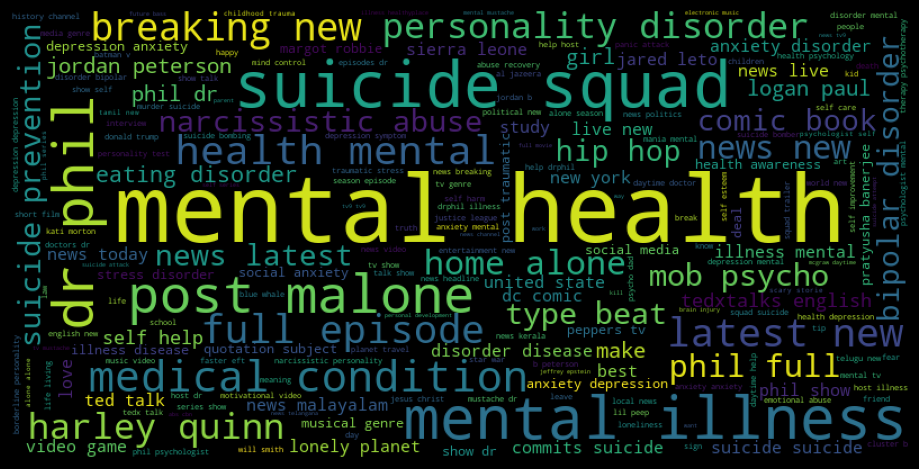

In [3]:
# add disorder to the key
from wordcloud import WordCloud, STOPWORDS

df_meta_mental = pd.read_csv("./metadata_mental_best.csv")
df_meta_mental = df_meta_mental.dropna(subset=["tags"])
df_meta_mental["tags"] = df_meta_mental["tags"].apply(lambda x: str(x).lower().replace(",", " "))
wordcloud = WordCloud(width=800, height=400, stopwords=STOPWORDS).generate(' '.join(df_meta_mental['tags']))

plt.figure(figsize=(9,6), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

From the graph, we see `meantal health` taking up the majority among the tags, justifying our extracted result. At the same time, it is interesting to find out that `disorder`, `narcissistic`, `abuse` consists of a large proportion in the tags which we overlook at first filtering the videos. So we may discuss and add them to the list above later. 

### 4. Number of mental health videos uploaded per day from 2006-2019

Finally it is time to show how much videos about mental health are uploaded per month and how much they grow over the years.

As shown in the figure, the growing video numbers regarding mental health indicates an increasing social attention in this topic. However, to be clearer about this, we need to further compare the trend with other topics and be sure it is not just because of general user growth in YouTube instead. 

Also, it it may be interesting to investiage further into the peaks (`2018.11`, `2016.7`...) in the graph to understand the cause. Could it be a relevant influencial event hosting in that month? Does it occur in any seasonal patterns? This are several points we want to look further in the final project.

In [4]:
def get_total_count(path):
    """
    Function to get total uploaded video number per date
    """
    total_count = pd.read_csv(path)
    total_count['upload_date'] = pd.to_datetime(total_count['upload_date'])

    total_count['upload_month'] = total_count['upload_date'].dt.to_period('M')
    total_count = total_count.groupby('upload_month')['value'].sum()#.to_dict()
    
    return total_count

def get_proportion(dataframe: pd.DataFrame, total_count: pd.Series):
    """
    Function to get the proportion of current topic videos to all videos uploaded in the same month
    """
    df = dataframe.copy()

    df["upload_month"] = pd.to_datetime(df["upload_date"]).dt.to_period('M')
    cur_count = df["upload_month"].value_counts()

    percentage = cur_count / total_count
    percentage = percentage.dropna()

    return percentage

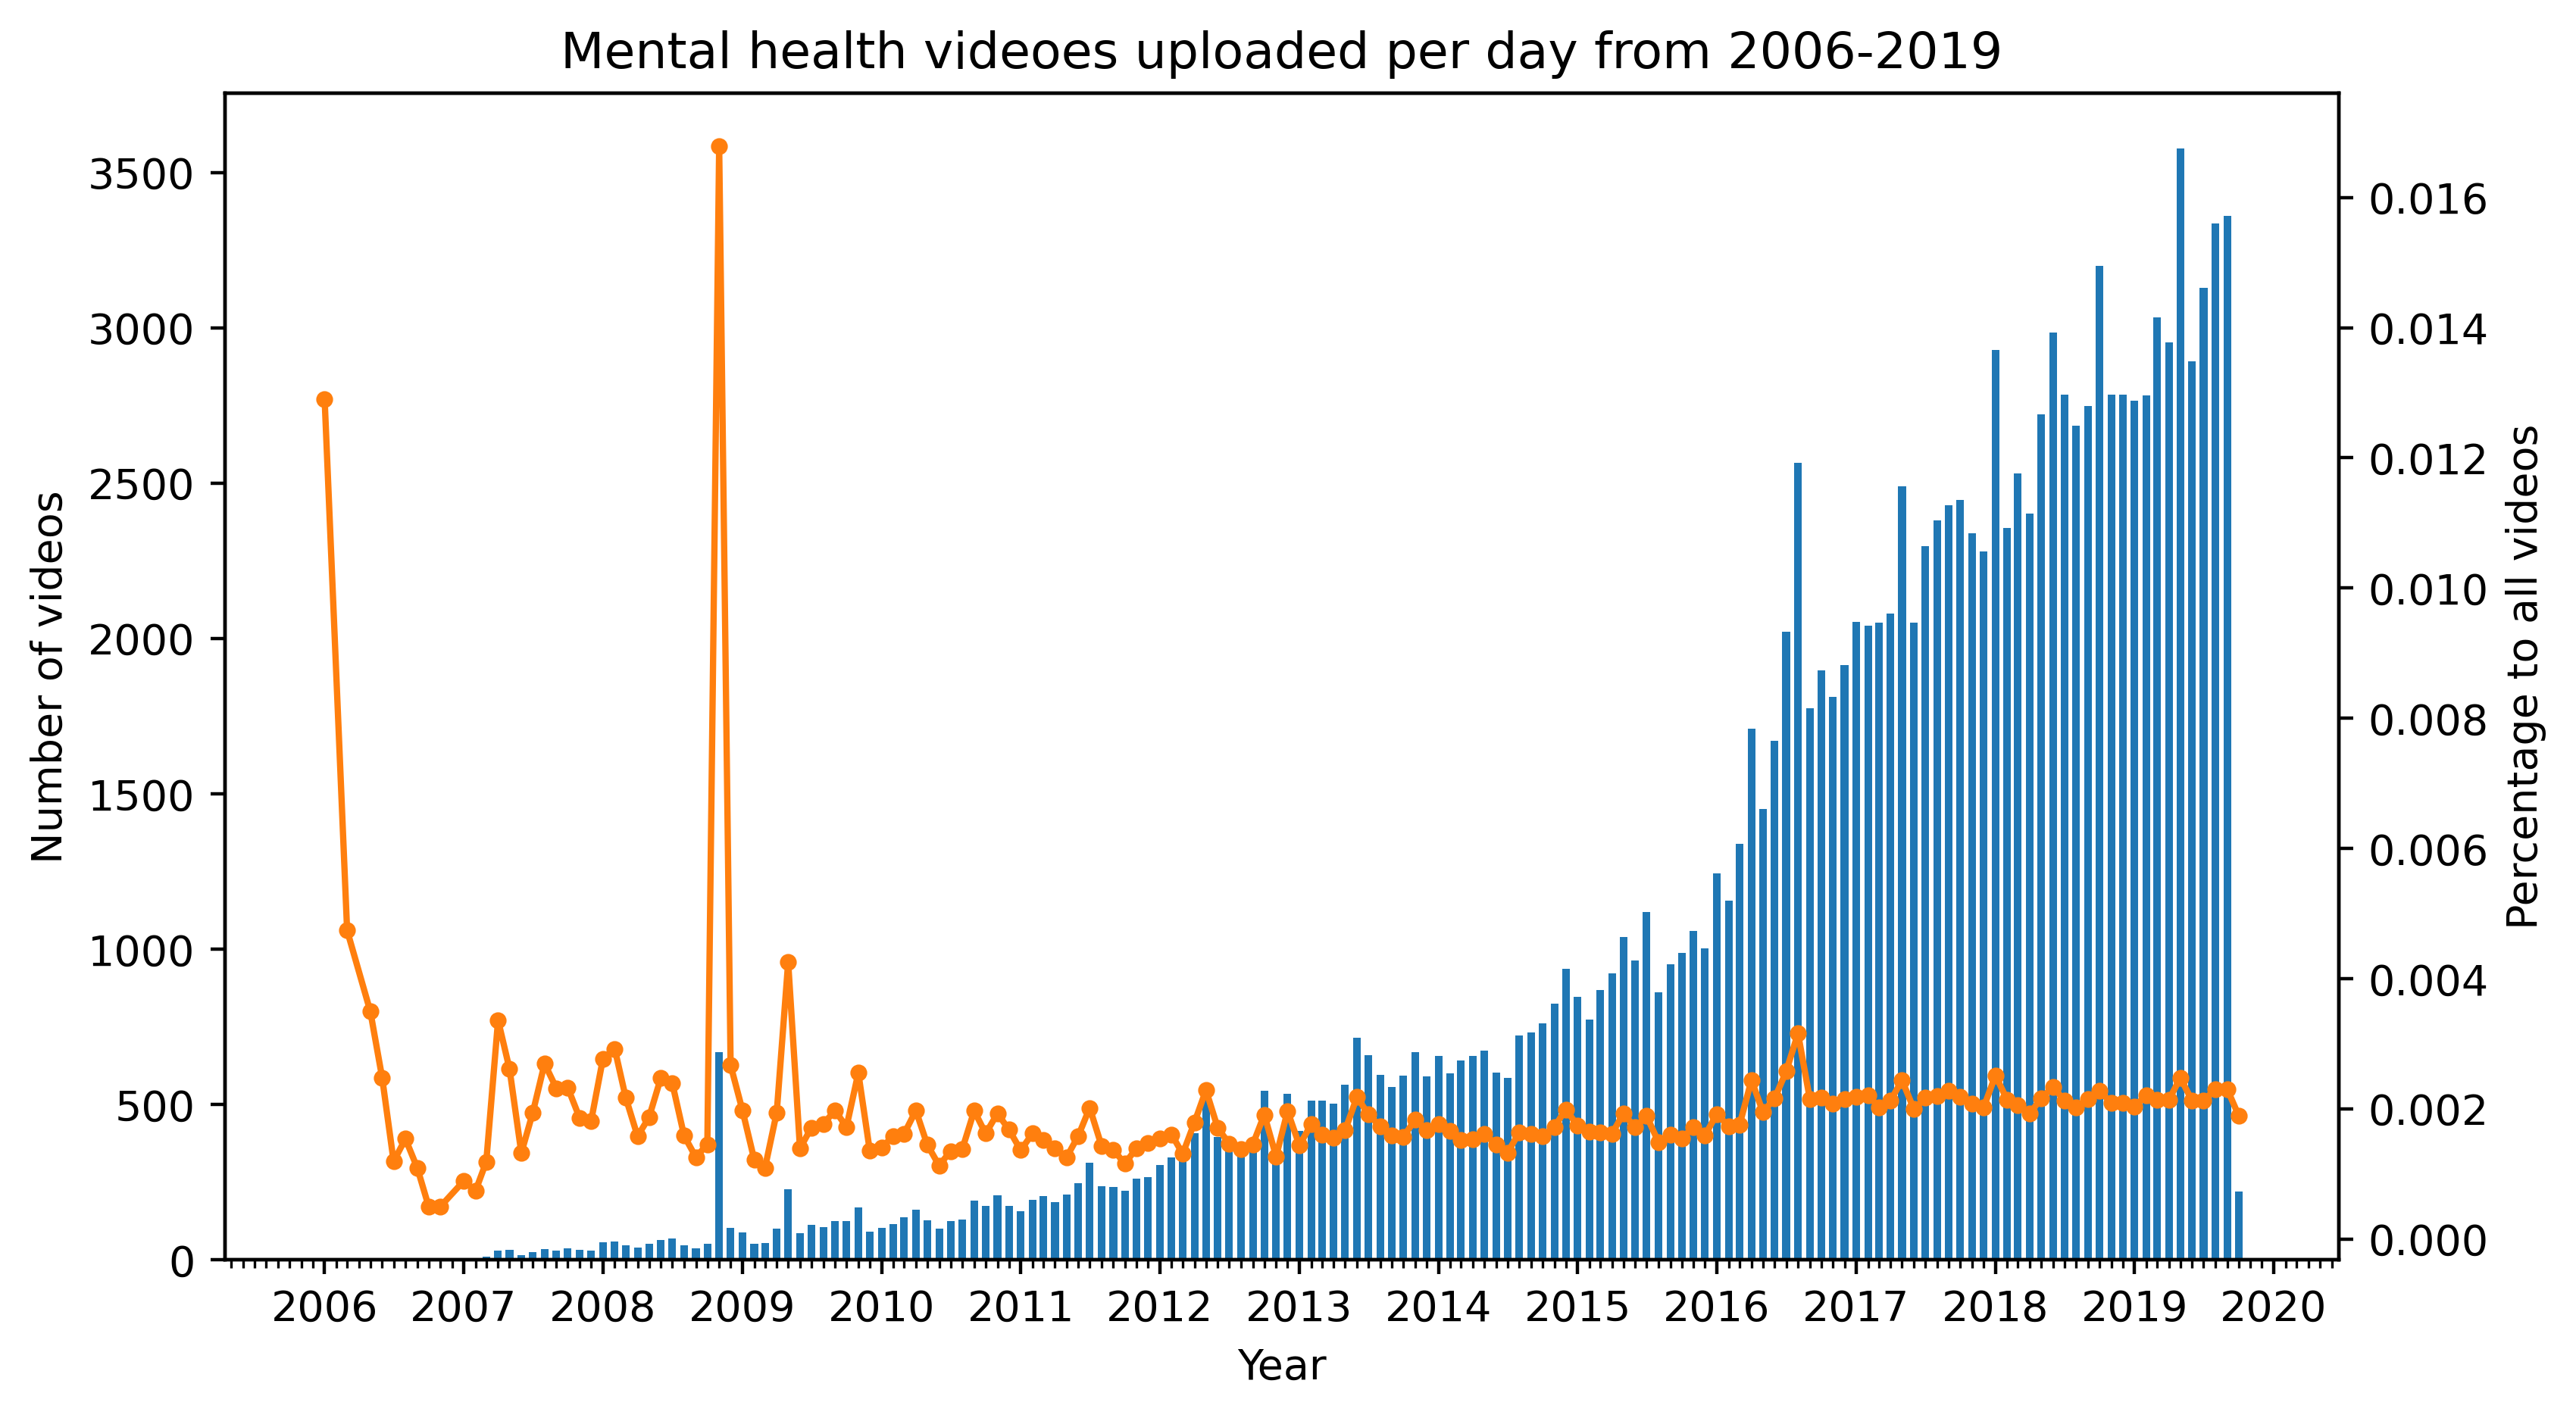

In [5]:
# aggregate based on upload time and plot the histogram
def transform_for_histplot(dataframe: pd.DataFrame):
    """
    Aggregate record numbers monthly based on upload_date
    Return sorted hitogram series
    """
    df = dataframe.copy()
    df.upload_date = pd.to_datetime(df.upload_date)
    df['upload_month'] = df['upload_date'].dt.to_period('M')
    df_hist = df['upload_month'].value_counts().sort_index()
    df_hist.index = df_hist.index.to_timestamp()
    return df_hist

df_meta_mental = pd.read_csv("./metadata_mental_best.csv")

fig, ax = plt.subplots(figsize=(9, 5), dpi=400)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())

ax.set_xbound(datetime.date(2006, 1, 1), datetime.date(2019, 11, 1))

# First plot, absolute size
mental_hist = transform_for_histplot(df_meta_mental)
ax.bar(mental_hist.index, mental_hist.values, width=20)

ax.set_xlabel("Year")
ax.set_ylabel("Number of videos")
ax.set_title("Mental health videoes uploaded per day from 2006-2019")

# Second plot, percentage
total_count = get_total_count("./total_count.csv")
mental_percentage = get_proportion(df_meta_mental, total_count)

ax2 = ax.twinx()
ax2.set_ylabel("Percentage to all videos")
ax2.plot(mental_percentage.index.to_timestamp(), mental_percentage.values, marker='.', color='tab:orange')

### 5. Comparing the trend with other topics
It is time to compare the uploaded video numbers to other topics: ["gender_fem", "pokemon", "ice", "babylon", "comedy", "equality", "black_friday", "climate", "chaplin"]

For better visualization, we adopt line plot instead of bar plot this time and use log scale for y axis.

Consider there are so many topics, we plot them in groups. So the first group is short-term and periodic topics. The second group refers to long-term trends and the third group is control group.

Aside from the first group, we couldn't seek a siginicant difference between the second the third groups of topics, which makes it harder to draw a conclusion that mental health should be categorized  as a long-term trend topic.

In [18]:
def load_dataframe(topics: list):
    """
    Load csv files of other topics into dataframes
    """
    df_dict = {}
    for topic in topics:
        df_dict[topic] = pd.read_csv("./metadata_%s.csv"%topic)
    return df_dict

compared_topics = ["gender_fem", "pokemon", "ice", "babylon", "comedy", "equality", "black_friday", "climate", "chaplin"]
df_dict = load_dataframe(compared_topics)

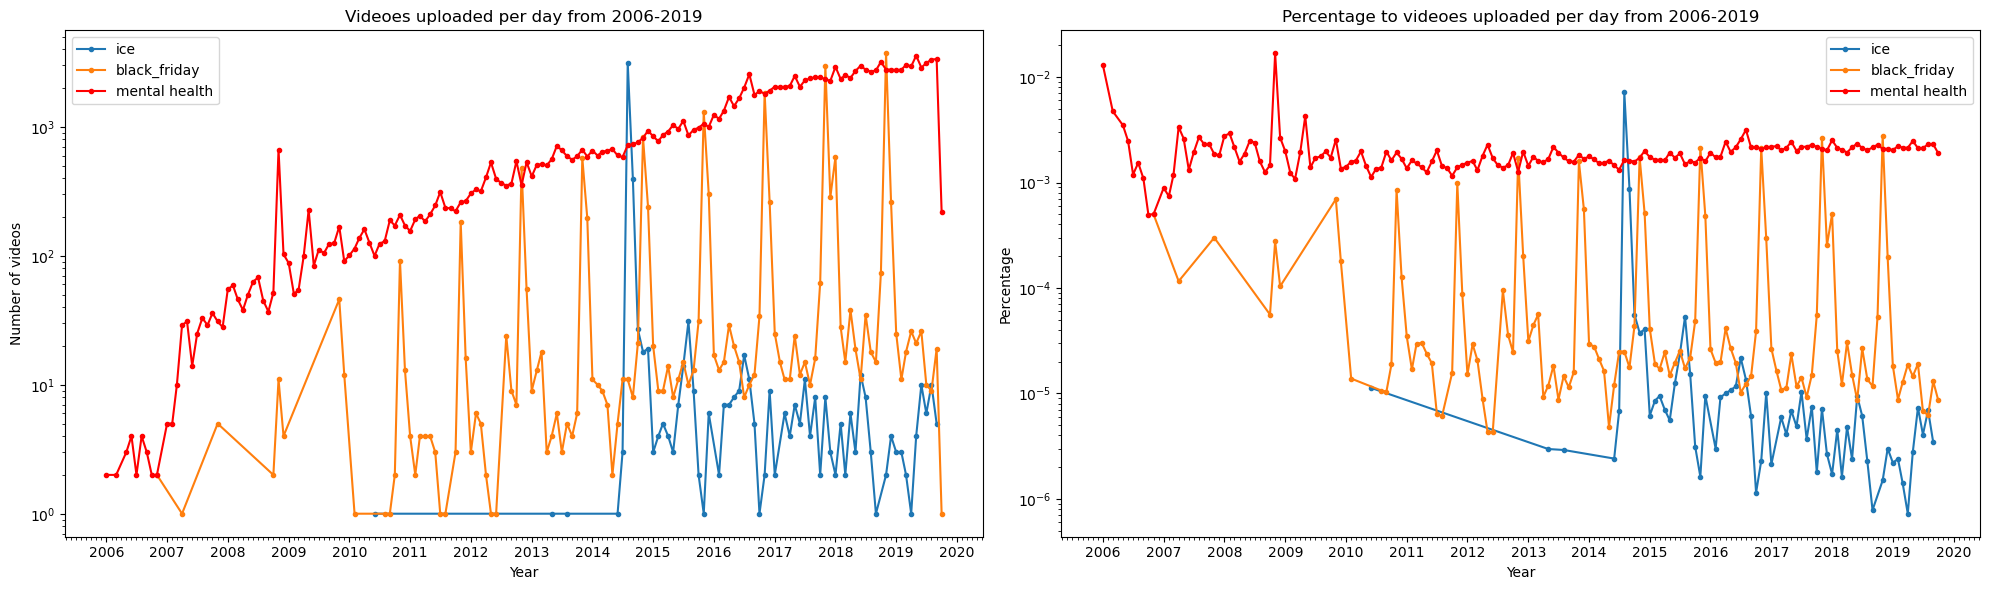

In [22]:
def plot_by_group(df_dict, total_count, mental_hist, mental_percentage, topic_list):

    plt.figure(figsize=(20, 6))

    # Plot the first subplot
    ax = plt.subplot(1, 2, 1)

    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())

    ax.set_xlabel("Year")
    ax.set_ylabel("Number of videos")
    ax.set_title("Videoes uploaded per day from 2006-2019")
    ax.set_yscale('log')

    ax.set_xbound(datetime.date(2006, 1, 1), datetime.date(2019, 11, 1))

    for topic in topic_list:

        df_topic = df_dict[topic]

        topic_hist = transform_for_histplot(df_topic)
        ax.plot(topic_hist, label=topic, marker='.')

    ax.plot(mental_hist, label="mental health", color="red", marker='.')
    ax.legend()

    # Plot the second subplot
    ax = plt.subplot(1, 2, 2)

    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())

    ax.set_xlabel("Year")
    ax.set_ylabel("Percentage")
    ax.set_title("Percentage to videoes uploaded per day from 2006-2019")
    ax.set_yscale('log')

    ax.set_xbound(datetime.date(2006, 1, 1), datetime.date(2019, 11, 1))

    for topic in topic_list:

        df_topic = df_dict[topic]

        topic_percentage = get_proportion(df_topic, total_count)
        ax.plot(topic_percentage.index.to_timestamp(), topic_percentage.values, marker='.', label=topic)

    ax.plot(mental_percentage.index.to_timestamp(), mental_percentage.values, marker='.', label="mental health", color="red")
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_by_group(df_dict, total_count, mental_hist, mental_percentage, ["ice", "black_friday"])

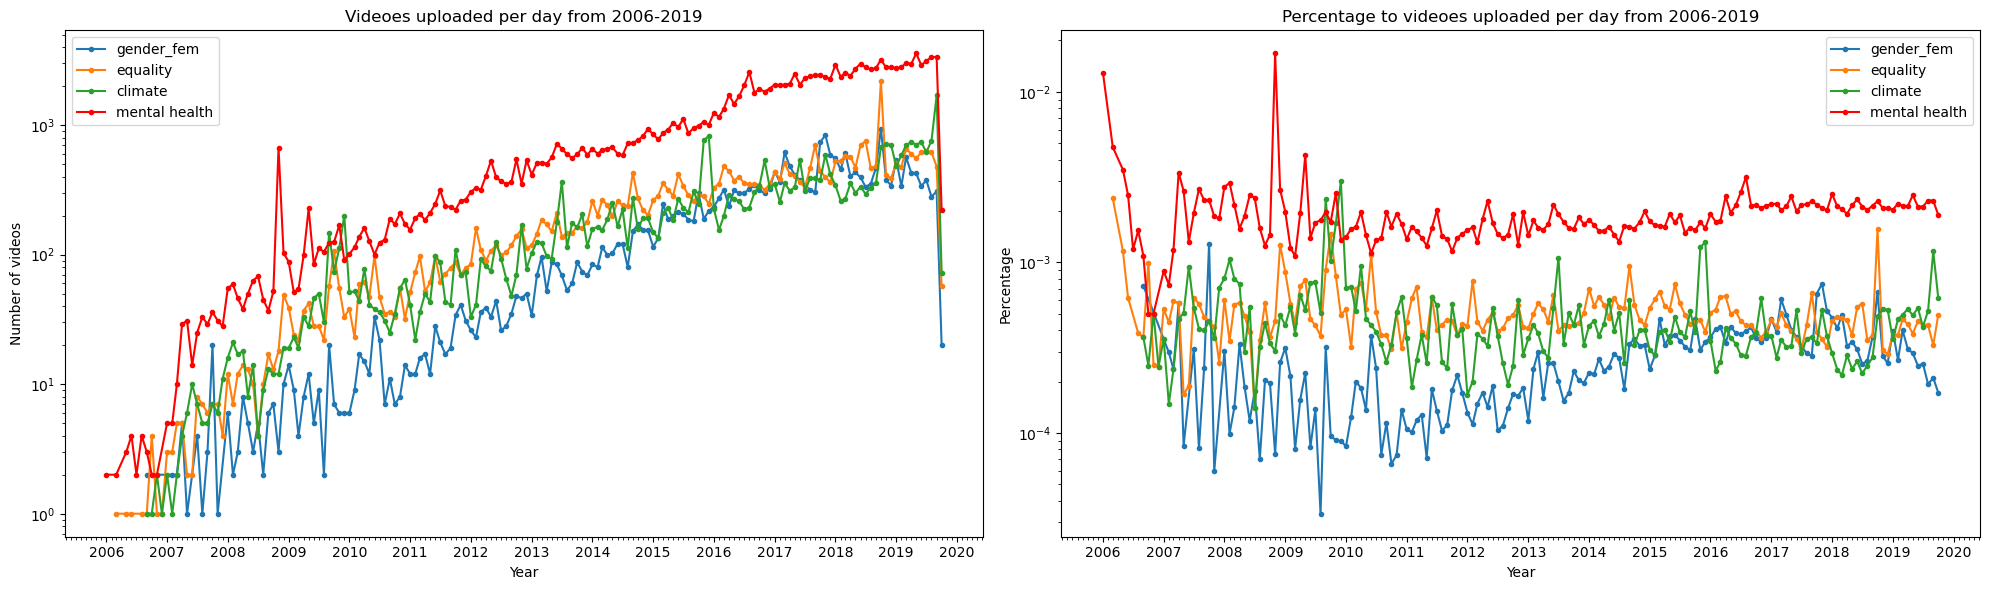

In [23]:
plot_by_group(df_dict, total_count, mental_hist, mental_percentage, ["gender_fem", "equality", "climate"])

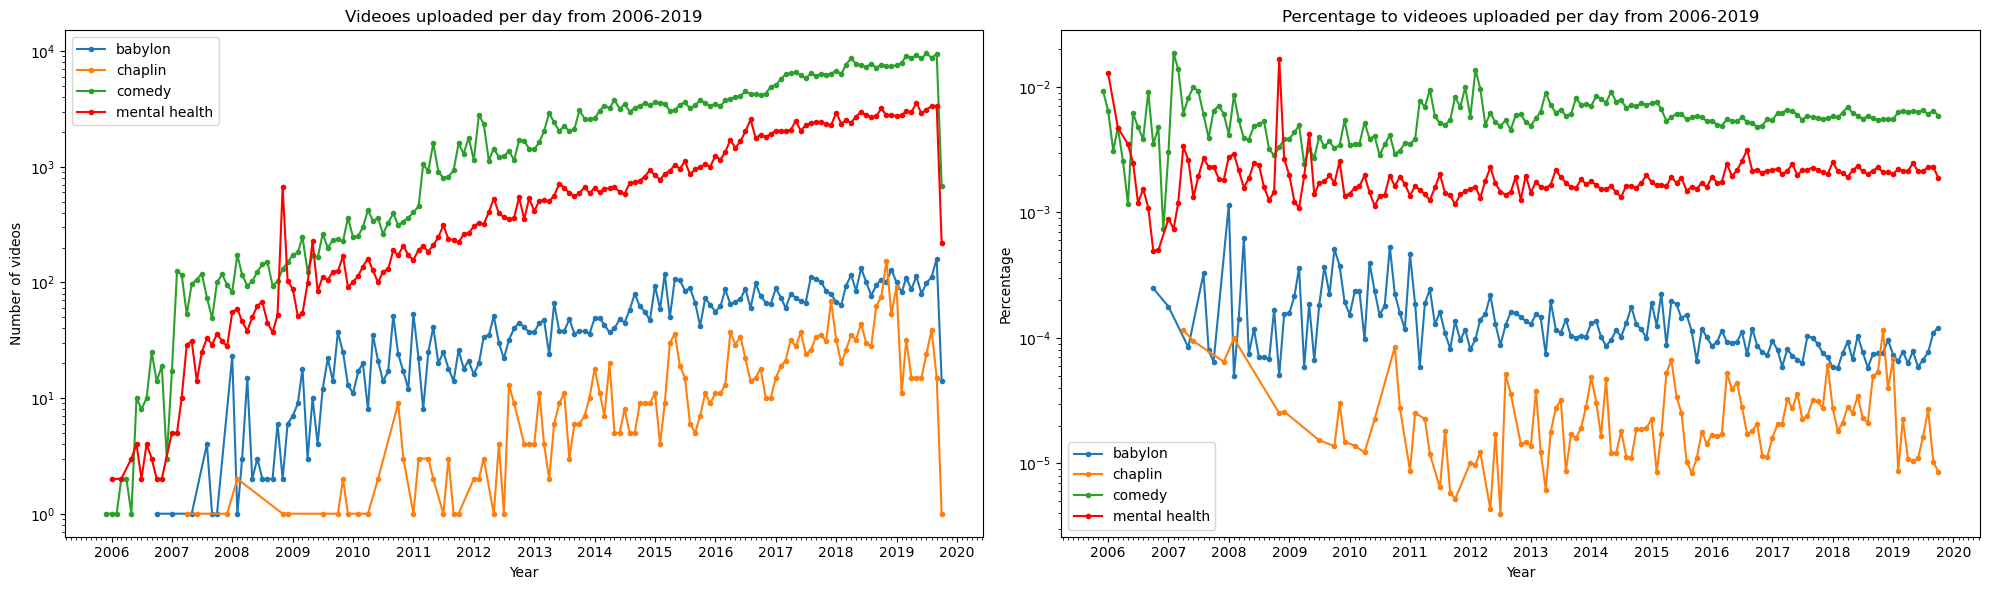

In [25]:
plot_by_group(df_dict, total_count, mental_hist, mental_percentage, ["babylon", "chaplin", "comedy"])

From the result we see: Videos related to mental health issues follow a gradual increase pattern, which either be categorized into long-term trend or control groups. But we couldn't draw a definite conclusion whether it has wide influence yet.

### 6. Explore predominant category in mental health videos
We divide the keywords into several categories according to our best knowledge, and calculate their frequency according to their appearance in the mental health videos. Patterns of these keywords may reveal some underlying factors determining the change of mental health videos.

In [8]:
df_meta_mental = pd.read_csv("./metadata_mental_best.csv")

# mental health types
mental_types = {
    # "general": ["mental health", "mental illness", "[^a-z0-9]emo[^a-z0-9]", "psycho", "psychiatr"],
    "lonely": ["solitude", "alone", "lonely", "loneliness"],
    "depress": ["depress"],
    "stress": ["stress",  "anxiety", "anxious"],
    "suicide": ["suicid"],
    "trauma": ["trauma", "ptsd"],
    "disorder": ["disorder"], # new
}

for m_type, keywords in mental_types.items():
    mental_types[m_type] = "|".join(keywords)

It is surprising to see that `suicide` takes up the majority within the specific categories, followed by `general` and `lonely`.

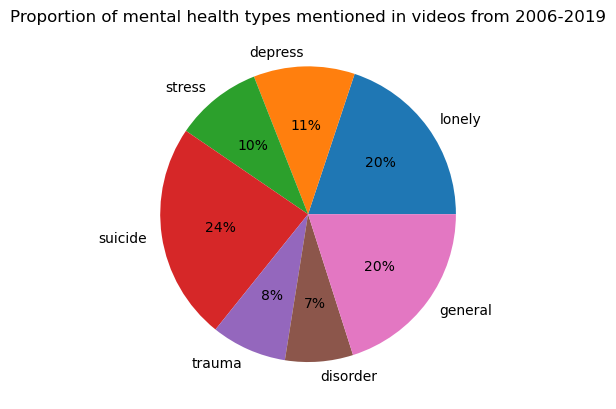

In [9]:
def count_type(dataframe: pd.DataFrame, mental_types: dict):
    """
    Count the occurence of each type
    If none of the types is detected, then it belongs to the general type
    """
    df = dataframe.copy()

    df["text"] = df["description"] + " " + df["tags"] + " " + df["title"]
    df["is_general"] = 1

    keywords_counter = Counter()

    for m_type, keywords in mental_types.items():
        if_contains_keywords = df["text"].str.lower().str.contains(keywords)

        keywords_counter[m_type] = if_contains_keywords.astype(int).sum()
        df.loc[if_contains_keywords, "is_general"] = 0

    keywords_counter["general"] = df["is_general"].sum()

    return keywords_counter

df_meta = df_meta_mental.copy()
types_counter = count_type(df_meta, mental_types)

# plot a bie chart for visualization
plt.title("Proportion of mental health types mentioned in videos from 2006-2019")
plt.pie(types_counter.values(), labels=types_counter.keys(), autopct='%.0f%%')
plt.show()

Also it would be interesting to see how the proportions are envolved during the years. While we could see some increase in regard to the suicide proportion, further conclusions toward the variantion needs to be investigated.

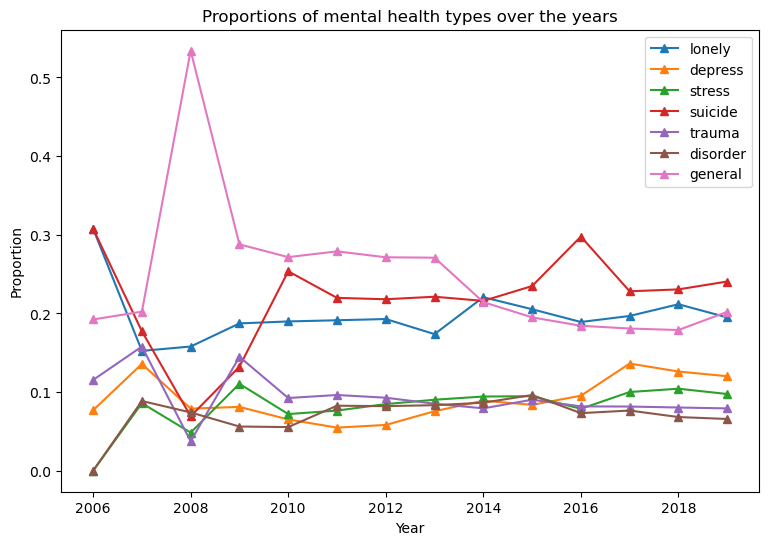

In [10]:
df_meta = df_meta_mental.copy()
df_meta["upload_date"] = pd.to_datetime(df_meta["upload_date"])

# initialize, keys are types, values are lists of proportion over the years
types_proportion_all = {}
for mental_type in mental_types.keys():
    types_proportion_all[mental_type] = []
types_proportion_all["general"] = []

# group by years
years = []
for year, df_group in df_meta.groupby(df_meta["upload_date"].dt.year):
    years.append(year)
    types_counter = count_type(df_group, mental_types)
    types_proportion = list(types_counter.values()) / sum(types_counter.values())
    for mental_type, proportion in zip(list(types_counter.keys()), types_proportion):
        types_proportion_all[mental_type].append(proportion)

plt.figure(figsize=(9, 6))

for mental_type, proportions in types_proportion_all.items():
    plt.plot(years, proportions, label=mental_type, marker='^')

plt.ylabel("Proportion")
plt.xlabel("Year")
plt.title("Proportions of mental health types over the years")
plt.legend()
plt.show()


# Time-series Data

In this part, we focus on processing the video time-series data. Two goals are to be achieved: 

1) **Detect a potential increase in views and subscribers for mental health related channels** : this goal can underline a possible trends and their behaviours. 

2) **Explore the distributions of views and subscribers** : for this goal, we can do it once with all the datetimes, once with first datetime for each channel (fixed time) and one for the last datetime. 

### 1. Exploratory analysis 
In this part, we will perform an exploratoring analysis on our time series dataset to observe the distribution of data within this dataset and to check the correspondence with the others (i.e. the first channel).

In [ ]:
# Loading the dataset
folder = "./data/"
df_timeseries = pd.read_csv(folder + "df_timeseries_en.tsv", sep="\t")

# Convert 'datetime' column to datetime object
df_timeseries['datetime'] = pd.to_datetime(df_timeseries['datetime'])

# Displaying the dataset
df_timeseries.head(2)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,202494.555556,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,394085.666667,191591.111111,1046.000000,395.777778,6,1,1


In [ ]:
# Let's see the category
categories = df_timeseries['category'].unique()
print(categories)

['Film and Animation' 'Music' 'Comedy' 'Gaming' 'Science & Technology'
 'Sports' 'Entertainment' 'Education' 'Nonprofits & Activism'
 'People & Blogs' 'Howto & Style' 'News & Politics' 'Travel & Events'
 'Autos & Vehicles' 'Pets & Animals' nan]


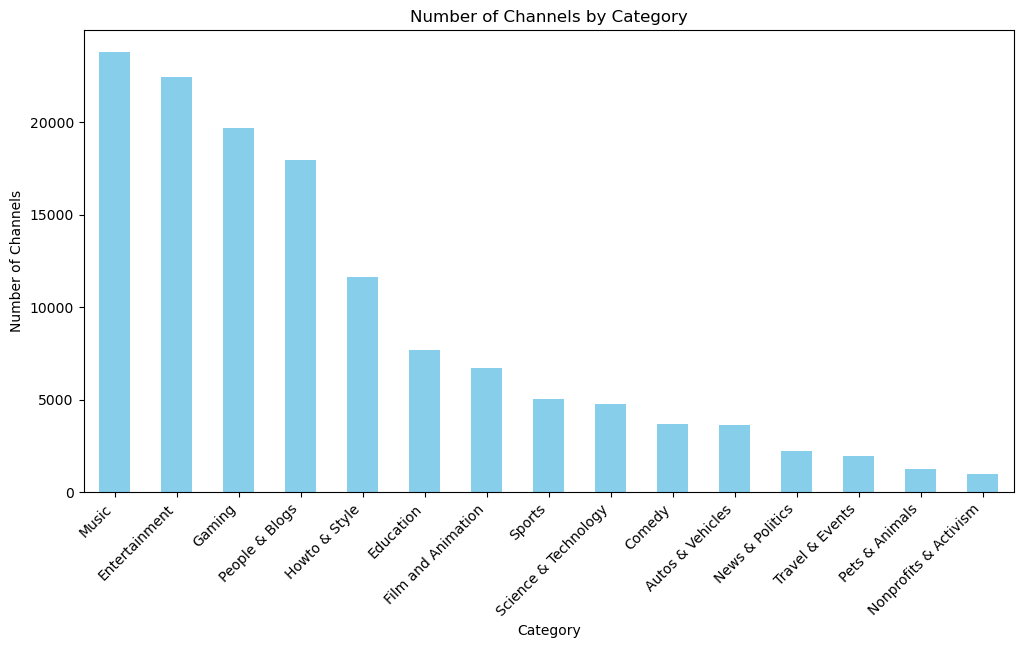

In [ ]:
# Counting the number of unique channels for each category
channel_counts = df_timeseries.groupby('category')['channel'].nunique()

# Sorting categories by channel count
sorted_categories = channel_counts.sort_values(ascending=False)

# Plotting the bar plot
plt.figure(figsize=(12, 6))
sorted_categories.plot(kind='bar', color='skyblue')
plt.title('Number of Channels by Category')
plt.xlabel('Category')
plt.ylabel('Number of Channels')
plt.xticks(rotation=45, ha='right')
plt.show()

### 2. Combining the metadata mental health dataset with the time series one :

In [ ]:
# Loading the metadata mental health related dataset
df_metadata = pd.read_csv(folder + "metadata_mental_best.csv")

# Creating a new sub-dataset from the time series one with only the channel_id coming from the metadata mental health dataset :
# Extract unique channel IDs from the metadata mental health dataset
mental_health_channel_ids = df_metadata['channel_id'].unique()

# Filter the time series dataset based on channel IDs
df_timeseries_mental_health = df_timeseries[df_timeseries['channel'].isin(mental_health_channel_ids)].copy()
timeseries_mental_health_channel_ids = df_timeseries_mental_health['channel'].unique()

# Set the normal indeces (0,1,2...)
df_timeseries_mental_health.reset_index(drop=True, inplace=True) 

# Display the new dataset
df_timeseries_mental_health.head(5)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCK-QfN_fautoBhHm2C4uECQ,Gaming,2016-08-29,7766234.00,18652.00,31357.250,0.000,3071,0,20
1,UCK-QfN_fautoBhHm2C4uECQ,Gaming,2016-09-05,7829982.00,63748.00,31581.000,223.750,3081,10,21
2,UCK-QfN_fautoBhHm2C4uECQ,Gaming,2016-09-12,7884526.00,54544.00,31798.000,217.000,3090,9,22
3,UCK-QfN_fautoBhHm2C4uECQ,Gaming,2016-09-19,7938265.00,53739.00,31986.125,188.125,3105,15,27
4,UCK-QfN_fautoBhHm2C4uECQ,Gaming,2016-09-26,7995220.75,56955.75,32167.500,181.375,3126,21,38


In [ ]:
print('Number of unique mental health related channels in the time series dataset :', len(timeseries_mental_health_channel_ids))

Number of unique mental health related channels in the time series dataset : 19137


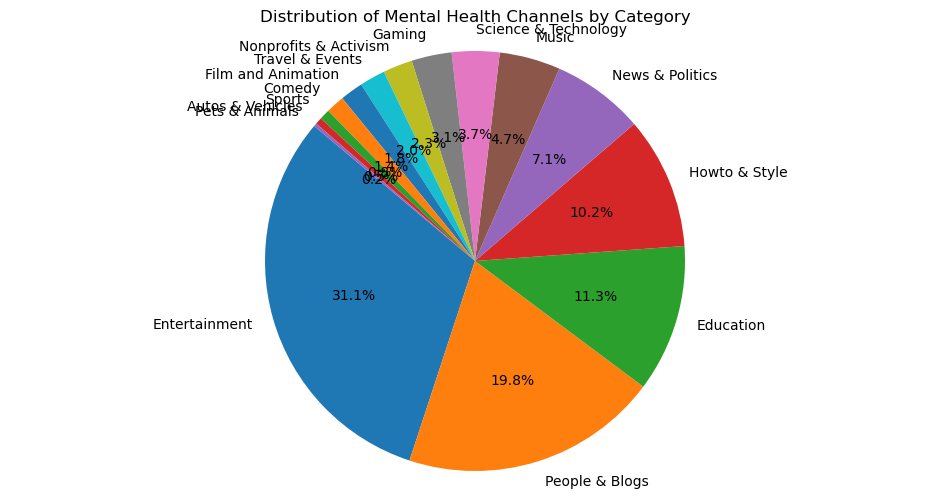

In [ ]:
# Counting the number of unique channels for each category in the metadata mental health dataframe
channel_counts_metadata = df_timeseries_mental_health.groupby('category')['channel'].nunique().reset_index(name='channel_count')

# Sorting categories by channel count
sorted_categories_metadata = channel_counts_metadata.sort_values(by='channel_count', ascending=False)

# # Creating an interactive pie chart
# fig_pie = px.pie(sorted_categories_metadata, names='categories', values='channel_count',
#             title='Distribution of Mental Health Channels by Category')
# # Show the plot
# fig_pie.show()

# Plotting a pie chart
plt.figure(figsize=(12, 6))
plt.pie(sorted_categories_metadata['channel_count'], labels=sorted_categories_metadata['category'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Mental Health Channels by Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

### 3. General Overview of the views distributions across all the channels

In [ ]:
# Sorting of the dataset for having each videos of one channel in order
df_timeseries_mental_health['datetime'] = pd.to_datetime(df_timeseries_mental_health['datetime'])  # Convert to datetime format

# Sort the DataFrame by "channel" and "datetime"
df_timeseries_mental_health = df_timeseries_mental_health.sort_values(by=['channel', 'datetime'])

# If you want to reset the index after sorting
df_timeseries_mental_health = df_timeseries_mental_health.reset_index(drop=True)

# Display the new dataset
df_timeseries_mental_health.head(5)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UC--24Q3_ZQeFmgJE-Um5QZQ,Travel & Events,2016-08-01,62524.500,4113.500,1466.000,0.000,29,0,1
1,UC--24Q3_ZQeFmgJE-Um5QZQ,Travel & Events,2016-08-08,67600.250,5075.750,1508.625,42.625,30,1,2
2,UC--24Q3_ZQeFmgJE-Um5QZQ,Travel & Events,2016-08-15,69982.000,2381.750,1530.750,22.125,31,1,2
3,UC--24Q3_ZQeFmgJE-Um5QZQ,Travel & Events,2016-08-22,72663.125,2681.125,1558.625,27.875,32,1,2
4,UC--24Q3_ZQeFmgJE-Um5QZQ,Travel & Events,2016-08-29,75093.000,2429.875,1591.000,32.375,33,1,2


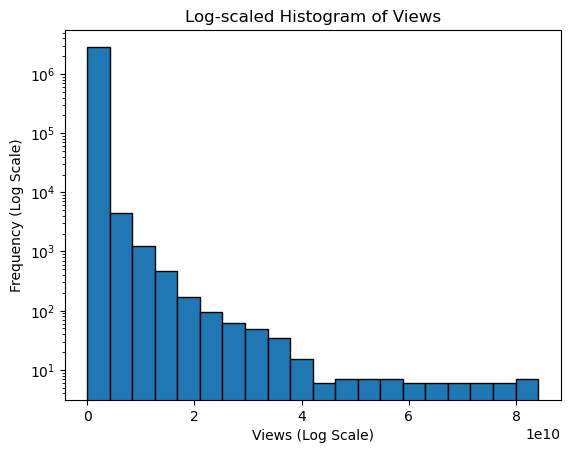

In [ ]:
views = df_timeseries_mental_health['views']

# Create histogram with log scale on y-axis
plt.hist(views, bins=20, log=True, edgecolor='black')

# Set labels and title
plt.xlabel('Views (Log Scale)')
plt.ylabel('Frequency (Log Scale)')
plt.title('Log-scaled Histogram of Views')

# Show the plot
plt.show()

### 4. General Overview of the views distributions across all the channels of their first and last datetime

We start by looking at the first datetime of each channel and we plot a views's histogram across all of them

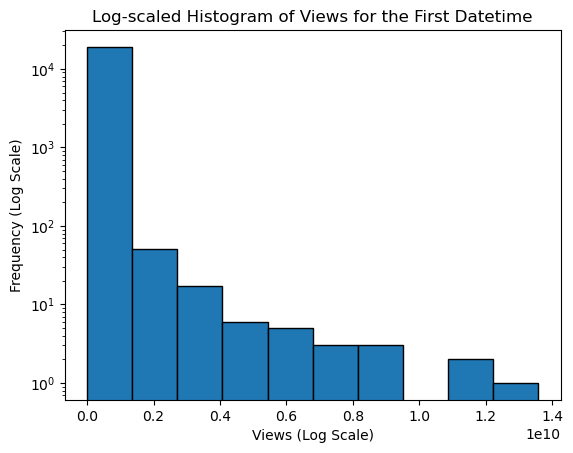

In [ ]:
# Creation of a dataframe with just the first video for each channel
df_timeseries_mental_health['datetime'] = pd.to_datetime(df_timeseries_mental_health['datetime'])  # Convert to datetime format

# Find the index of the first datetime for each channel
first_datetime_index = df_timeseries_mental_health.groupby('channel')['datetime'].idxmin()

# Extract rows corresponding to the first datetime for each channel
df_first_datetime = df_timeseries_mental_health.loc[first_datetime_index]

# Extract the (first) views
views = df_first_datetime['views']

# Create histogram with log scale on y-axis
plt.hist(views, bins=10, log=True, edgecolor='black')

# Set labels and title
plt.xlabel('Views (Log Scale)')
plt.ylabel('Frequency (Log Scale)')
plt.title('Log-scaled Histogram of Views for the First Datetime')

# Show the plot
plt.show()

Now, we look at the last datetime of each channel and we plot a views's histogram across all of them

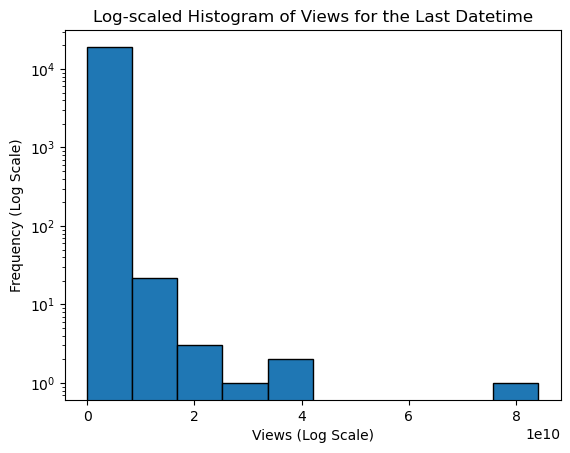

In [ ]:
# Creation of a dataframe with just the last video for each channel
df_timeseries_mental_health['datetime'] = pd.to_datetime(df_timeseries_mental_health['datetime'])  # Convert to datetime format

# Find the index of the last datetime for each channel
last_datetime_index = df_timeseries_mental_health.groupby('channel')['datetime'].idxmax()

# Extract rows corresponding to the last datetime for each channel
df_last_datetime = df_timeseries_mental_health.loc[last_datetime_index]

# Extract the (last) views
views = df_last_datetime['views']

# Create histogram with log scale on y-axis
plt.hist(views, bins=10, log=True, edgecolor='black')

# Set labels and title
plt.xlabel('Views (Log Scale)')
plt.ylabel('Frequency (Log Scale)')
plt.title('Log-scaled Histogram of Views for the Last Datetime')

# Show the plot
plt.show()

# Channel Metadata
In this part, we will focus on processing the channel metadata. 
1. **Filtering the channel** : find the corresponding channel of the filtered video metadata containing the keywords
2. **Do some basic analysis of the fitered channel metadata**

In [ ]:
folder = './data' 
df_channels = pd.read_csv(folder + "df_channels_en.tsv", sep="\t")
df_metadata = pd.read_csv(folder + "metadata_mental_best.csv")

### 1. Combining the metadata mental health dataset with the channel metada one :

Filter the channel dataset according to the mental health videos

In [ ]:
# filter the channel with realeased videos about mental health
filtered_dataset = df_channels[df_channels['channel'].isin(df_metadata['channel_id'])]
filtered_dataset

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.0870
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.0870
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.0870
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.0870
8,Entertainment,2015-05-12,UCk8GzjMOrta8yxDcKfylJYw,✿ Kids Diana Show,34700000,599,16.0,2.0870
...,...,...,...,...,...,...,...,...
136434,Entertainment,2016-12-08,UCHhADtMaBfxHgDWH4unda6w,Kool Khaizer,10105,13,995516.0,53.1435
136435,People & Blogs,2008-12-27,UCnjDQQeRXmBVZTI8Nw9BRYQ,Wolfla The Wolf,10100,545,995627.0,53.1435
136442,People & Blogs,2018-07-11,UC9mdbZJBLOWQkHIpoaJPjeQ,_Nevaeh Crockett_,10100,54,996760.0,53.1435
136463,Entertainment,2016-11-08,UCf0RCfzyKoGr5AnLldeI1xw,On The Marc,10028,307,1007560.0,53.1435


### 2. The  number of subscribers of these channels
Most of the channels are with the number of subscribers less than 2 * 10 ^ 7. Only a few of these channels is above 4 * 10 ^ 7. 

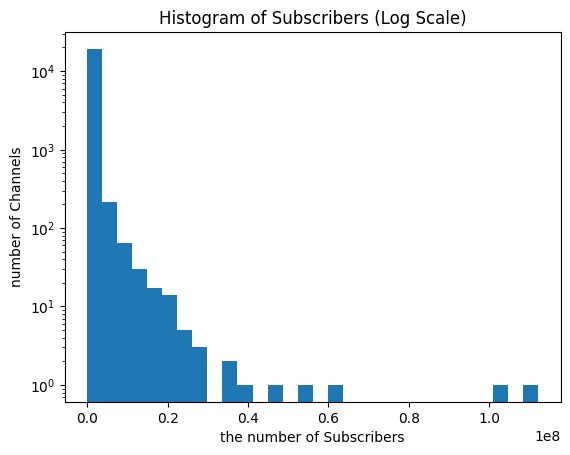

In [ ]:
plt.hist(filtered_dataset['subscribers_cc'], bins=30, log=True)
plt.xlabel('the number of Subscribers')
plt.ylabel('number of Channels')
plt.title('Histogram of Subscribers (Log Scale)')
plt.show()

Next, we take a look at these channels according to their ranks. 

Text(0, 0.5, 'the number of subscribers')

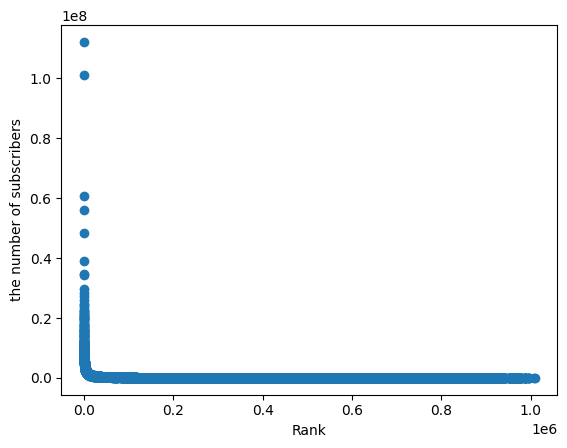

In [ ]:
plt.scatter(filtered_dataset['subscriber_rank_sb'], filtered_dataset['subscribers_cc'])

plt.xlabel('Rank')
plt.ylabel('the number of subscribers')

The scatterplot is hard to see the changes, so we take the log of the number of the subscribers and make the size of the plots smaller. 

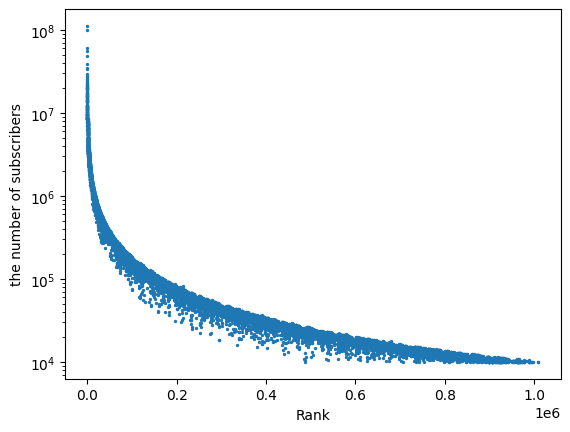

In [ ]:
plt.scatter(filtered_dataset['subscriber_rank_sb'], filtered_dataset['subscribers_cc'], s =2)
plt.xlabel('Rank')
plt.ylabel('the number of subscribers')
plt.yscale('log')  # This line sets the y-axis to log scale

plt.show()

We witness a sharp decrease around 10^5. After that, the trend decreases slowly, which means that after that the number of subscribers is quite similar but rank varies a lot. 

Now we try to find out does the number of the uploaded videos affect the channels ranking? 

Text(0, 0.5, 'the number of videos uploaded')

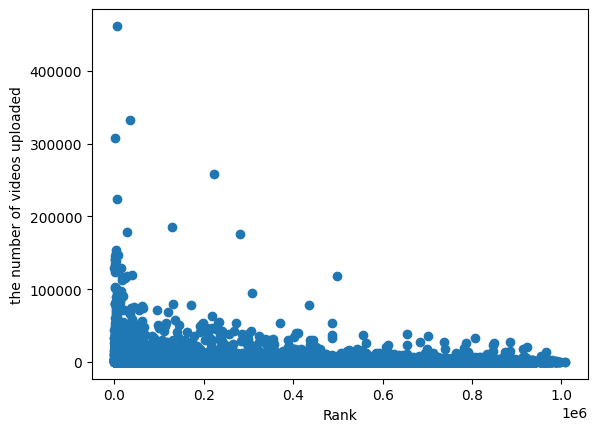

In [ ]:
plt.scatter(filtered_dataset['subscriber_rank_sb'], filtered_dataset['videos_cc'])

plt.xlabel('Rank')
plt.ylabel('the number of videos uploaded')

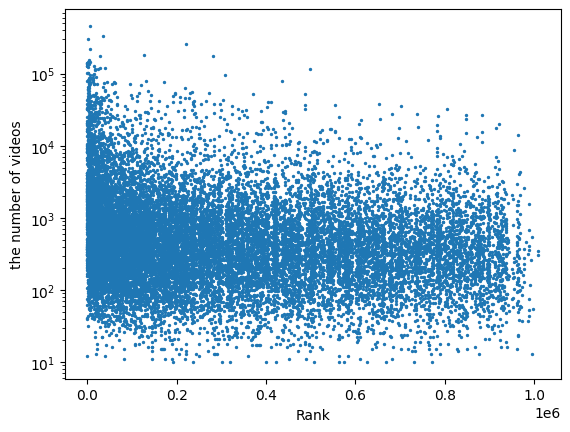

In [ ]:
plt.scatter(filtered_dataset['subscriber_rank_sb'], filtered_dataset['videos_cc'], s =2)
plt.xlabel('Rank')
plt.ylabel('the number of videos')
plt.yscale('log')  # This line sets the y-axis to log scale

plt.show()

We can see that there is no significant correlations between video rank and the number of videos it released. So the rank could depend on the quality of the video but not the quantity. 

### 3. The joining date of these channels from 2005 to 2019
Now let's look at the joining year of the channels. We first extract the first four numbers of the joining date(year), and see the trend of it. 

/var/folders/55/m_srhfjd3178_f4w0ztbx7qr0000gn/T/ipykernel_9283/2877288283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset['year'] = filtered_dataset['join_date'].astype(str).str[:4]


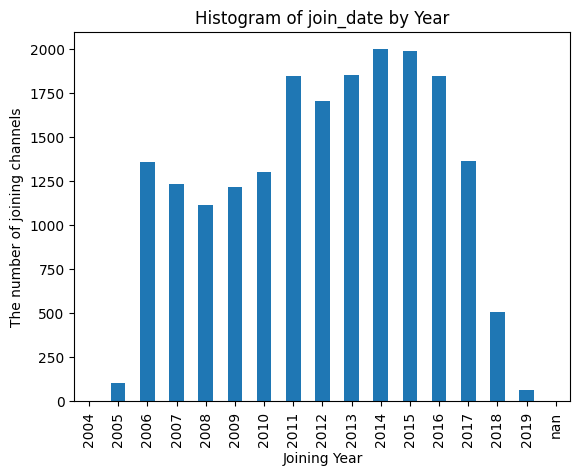

In [ ]:
# Extract the first four numbers (year) from the "join_date" column
filtered_dataset['year'] = filtered_dataset['join_date'].astype(str).str[:4]

# Group the data by year and count the occurrences
year_counts = filtered_dataset['year'].value_counts().sort_index()

# Create a histogram using the counts for each year
year_counts.plot(kind='bar')
plt.xlabel('Joining Year')
plt.ylabel('The number of joining channels')
plt.title('Histogram of join_date by Year')
plt.show()

We can see that there is a increase from 2008 to 2014, and a decrease from 2014 to 2018. We delete the year 2019 because the data is incompleted. We will try to figure out the potential reasons for the changes and discuss further later. 